# *Lecture 13*

# Multivariate Functions and Monte Carlo Methods

### Introduction

We saw how to minimize a multivariate function by using a gradient approach.
Today we see another application from physics.

We also return to Monte Carlo integration to prepare for multidimensional Monte Carlo integration.

## Application: Maximum Likelihood Estimator in Higgs Boson Search

In a search for new particles, we expect the observed data to be composed of "signal" and "background" events.
If we have some way to estimate the expected background contribution $b$, then we can use the observed number of data events $n$ to provide an estimate of the number of signal events $s$.
The most likely value of $s$ is the one that maximizes the likelihood function based on the Poisson probability:

$$L(n,s,b) = \frac{e^{-s-b} (s+b)^n}{n!}$$

It is more common to minimize $-\ln L$ in this calculation.

$$\ln L(n,s) = -s -b + n\ln(s+b) - \ln n!$$
$$-\ln L(n,s) = s +b - n\ln(s+b) + \ln n!$$

In this case, we can even calculate the derivative analytically:

$$\frac{\partial \ln L}{\partial s} = -1 + \frac{n}{s+b}$$


In [1]:
import numpy as np
from math import factorial
def lnL(n, s, b):
    return s + b - n*np.log(s+b) + np.log(factorial(n))

def dlnLds(n, s, b):
    return 1 - n/(s+b)

# some tests of the functions
print(lnL(3, 1.0, 1.9))
print(dlnLds(3, 1.0, 1.9))

1.4976272582507701
-0.034482758620689724


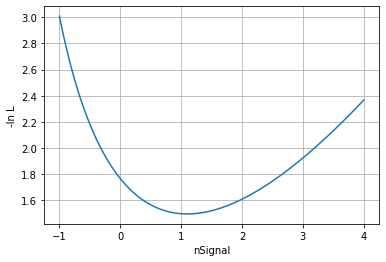

In [2]:
import matplotlib.pyplot as plt
nobs = 3
nbkg = 1.9
svalues = np.linspace(-1, 4, 100)
plt.plot(svalues, lnL(nobs, svalues, nbkg))
plt.xlabel('nSignal')
plt.ylabel('-ln L')
plt.grid(); plt.show()

The `nSignal` value that minimizes $-\ln L$ is the most probable value.
You may also remember that $\pm 1 \sigma$ corresponds to 0.5 units of $\ln L$ above the minimum.
How can we find the correct measurement, with uncertainties?
Clearly we should look for the point where $\partial \ln L/\partial s = 0$.

In [3]:
s = 0. # starting point
ds = 0.01
eps = 0.01
imax = 10

# Find the most probable value
for it in range(0, imax + 1):
    F = dlnLds(nobs, s, nbkg)
    if ( abs(F) <= eps ):                         # Check for convergence
        print("Root found at s = %.5f, F = %.5e, tolerance eps = %e" % (s, F, eps)) 
        break
    print("Iteration ", it, " s = ", s, ", dlnLds(s) = ", F)
    df = (dlnLds(nobs, s + ds, nbkg) - dlnLds(nobs, s, nbkg))/ds
    ds = - F/df 
    s += ds                                               # New guess
    
signal_mpv = s

Iteration  0  s =  0.0 , dlnLds(s) =  -0.5789473684210527
Iteration  1  s =  0.70033333333334 , dlnLds(s) =  -0.1536982438148926
Iteration  2  s =  1.1400554814814827 , dlnLds(s) =  0.013175904757489199
Root found at s = 1.09359, F = -2.13987e-03, tolerance eps = 1.000000e-02


In [4]:
# Now find the places where ln L changes by 0.5 units.
minL = lnL(nobs, signal_mpv, nbkg)
print("minL value is", minL)

def f(s):
    return lnL(nobs, s, nbkg) - minL - 0.5

def bisection(xminus, xplus, Nmax, eps):       # x-,x+ Nmax error
    for it in range(0,Nmax):
        x=(xminus+xplus)/2                     # Mid point
        print("iteration %2d: x = %.6f and f(x) = %9.6f" % (it, x, f(x)))
        if (f(xplus)*f(x)>0):                      # Root in other half
            xplus=x                            # Change x+ to x
        else:
            xminus=x                           # Change x- to x
        if(xplus-xminus<eps):                           # Converged?
            print("root found with precision eps = ",eps)
            break
        if it==Nmax-1:
             print("root not found after Nmax iterations ")   
    return x

minus1sigma = bisection(-1., signal_mpv, 1000, 0.01)
plus1sigma  = bisection(signal_mpv, 4., 1000, 0.01)
print(minus1sigma, plus1sigma)

minL value is 1.4959294522514823
iteration  0: x = 0.046797 and f(x) = -0.255929
iteration  1: x = -0.476601 and f(x) =  0.160087
iteration  2: x = -0.214902 and f(x) = -0.084543
iteration  3: x = -0.345752 and f(x) =  0.027102
iteration  4: x = -0.280327 and f(x) = -0.031170
iteration  5: x = -0.313039 and f(x) = -0.002671
iteration  6: x = -0.329396 and f(x) =  0.012053
iteration  7: x = -0.321218 and f(x) =  0.004651
root found with precision eps =  0.01
iteration  0: x = 2.546797 and f(x) = -0.233925
iteration  1: x = 3.273399 and f(x) =  0.038639
iteration  2: x = 2.910098 and f(x) = -0.106224
iteration  3: x = 3.091748 and f(x) = -0.035780
iteration  4: x = 3.182573 and f(x) =  0.000950
iteration  5: x = 3.137161 and f(x) = -0.017537
iteration  6: x = 3.159867 and f(x) = -0.008324
iteration  7: x = 3.171220 and f(x) = -0.003694
iteration  8: x = 3.176897 and f(x) = -0.001374
root found with precision eps =  0.01
-0.3212175404799289 3.1768967643398214


In [5]:
print("The fitted value for the Higgs signal is %.2f (+ %.2f - %.2f)" 
          % (signal_mpv, minus1sigma-signal_mpv, plus1sigma-signal_mpv))

The fitted value for the Higgs signal is 1.09 (+ -1.41 - 2.08)


The fitted value for the Higgs signal is $1.09 ^{+2.08} _{-1.41}$ events.

# Follow-up on Monte Carlo Methods

In previous lectures, we introduced Monte Carlo methods to accomplish two purposes:
* numerically integrate a function without recourse to analytic expansions like the trapezoid rule, Simpson's rule
* simulate physical states contributing to the integration

In some cases, the physics state configurations are as important or more important than the integrand.
There was a taste of this in the Markov chain Monte Carlo method (Metropolis algorithm), in which new states were created and explored algorithmically without too much input from us.

The functional integrations were all 1-dimensional, just to introduce the methods.

## Recap of 1-D MC Convergence

$$\int_0^\pi \sin x\ dx$$

In Exercise Set \#3, you estimated a certain integral using MC methods  and found the dependence of the error on $N$.  Let's recap what we expect for convergence of the numerical integration algorithms.

For the trapezoid method, which uses a linear approximation of the function, we expect the error to scale as $1/N^2$.  (For Simpson's method it was $1/N^4$.)

<img src="Figures/Trapezoid_rule.png" width="50%">

For the Monte Carlo method, you showed that the convergence was $1/\sqrt{N}$.
This is not as good as the other methods in 1-D cases.

In [6]:
import numpy as np
import random

def f(x):
    return np.sin(x)

def wTrap(i, h, N):                # Total weight definition function
    if ( (i == 1) or (i == N) ):
        wTotal = h/2.0
    else:
        wTotal = h
    return wTotal

def integration_trapezoid(f, a, b, N):
    h = (b - a)/(N - 1)
    sum = 0.
    for i in range(1, N + 1):
        t = a + (i - 1)*h
        this_term = wTrap(i, h, N) * f(t)
        sum  += this_term
    result = sum
    error = abs(result - 2.000)
    return (result, error)

def integration_MC(f, a, b, N):
    sum = 0.
    sum2 = 0.
    for i in range(N):
        x = random.uniform(a, b)
        sum += f(x)
        sum2 += pow(f(x),2)
    result = (b - a) * sum/N
    sigma = (b - a) * np.sqrt((sum2/N - pow(sum/N,2))/N)
    error = abs(result - 2.000)
    return (result, error)

In [7]:
for N in np.logspace(1, 5, num=5, dtype=int):
    print("N =", N)
    print("Trap:", integration_trapezoid(f, 0, np.pi, N))
    print(" MC :", integration_MC(f, 0, np.pi, N))

N = 10
Trap: (1.9796508112164835, 0.020349188783516547)
 MC : (1.7705797062849384, 0.22942029371506156)
N = 100
Trap: (1.9998321638939918, 0.0001678361060082345)
 MC : (1.946511059796887, 0.0534889402031129)
N = 1000
Trap: (1.9999983517708506, 1.6482291493868928e-06)
 MC : (2.0023922915295196, 0.0023922915295195857)
N = 10000
Trap: (1.999999983547363, 1.6452637030539563e-08)
 MC : (1.987793244049618, 0.012206755950382009)
N = 100000
Trap: (1.9999999998355142, 1.6448575834715484e-10)
 MC : (2.000677372115895, 0.0006773721158950252)


I don't even have to make a plot here for us to see the trend with $N$.  You can see that the error from the trapezoid decreases by a factor of 100 each time, while the error from the MC method decreases by a factor of $\sqrt{10}\approx 3$ each time, on average.

You might notice that the convergence of the MC method is not as smooth and reliable.
Sometimes the error decreases by a factor of 8, and sometimes hardly at all.  This is just a consequence of the pseudo-random number chosen as part of the uniform sampling.
The result seems trustworthy only for a large number of points.

Can we do better?

## Quasi-Monte-Carlo Methods

The idea of the quasi-Monte-Carlo methods is to replace the random number sequence with a sequence that covers the domain more uniformly and predictably.

This does not go against the Monte Carlo method: random numbers were just a convenient way of sampling the space efficiently.
If we have a more efficient way, then we should use it.

### Low-Discrepancy Number Sequences

"Low discrepancy" means that a sequence is unlikely to have clusters in any dimension.
Two of the most commonly-used sequences are the 
[Halton sequence](https://en.wikipedia.org/wiki/Halton_sequence") and the [Sobol sequence](https://en.wikipedia.org/wiki/Sobol_sequence).
We will focus on the Halton sequence because it has a simpler implementation.

The Halton sequence is the N-dimensional version of this kind of sequence:

$$\frac{1}{2}, \frac{1}{4}, \frac{3}{4}, \frac{1}{8}, \frac{5}{8}, \frac{3}{8}, \frac{7}{8}$$

by which the interval is covered uniformly, but not really "randomly."
(Note that the long-range correlations, which might seem large at first, disappear as more terms are added.)

In [8]:
def halton(dim, nbpts):
    # Author: Sebastien Paris
    # Translation from C: Josef Perktold
    h = np.empty(nbpts * dim)
    h.fill(np.nan)
    p = np.empty(nbpts)
    p.fill(np.nan)
    P = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]
    lognbpts = np.log(nbpts + 1)
    for i in range(dim):
        b = P[i]
        n = int(np.ceil(lognbpts / np.log(b)))
        for t in range(n):
            p[t] = pow(b, -(t + 1) )

        for j in range(nbpts):
            d = j + 1
            sum_ = np.fmod(d, b) * p[0]
            for t in range(1, n):
                d = np.floor(d / b)
                sum_ += np.fmod(d, b) * p[t]

            h[j*dim + i] = sum_

    return h.reshape(nbpts, dim)

[[0.5        0.33333333]
 [0.25       0.66666667]
 [0.75       0.11111111]
 [0.125      0.44444444]
 [0.625      0.77777778]]
[[0.64438613 0.82136553]
 [0.69149624 0.89739454]
 [0.73556475 0.6289532 ]
 [0.43019739 0.0240197 ]
 [0.03117315 0.35771961]]


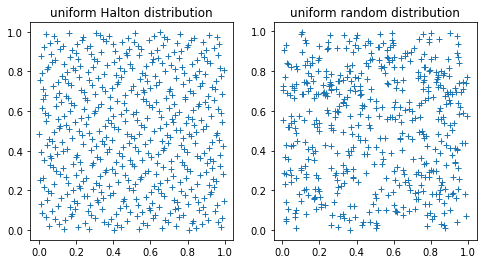

In [9]:
x_halton = halton(2, 5000);
print(x_halton[:5])

x_random = np.random.random((5000,2))
print(x_random[:5])

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(x_halton[:500, 0], x_halton[:500, 1], '+')
plt.title('uniform Halton distribution')

plt.subplot(1,2,2)
plt.plot(x_random[:500, 0], x_random[:500, 1], '+')
plt.title('uniform random distribution')

plt.show()

Now let's use this new quasi-random number sequence in "quasi-Monte Carlo" integration.  The general formula for Monte Carlo integration is the same, only the $x_i$ values are new.

In [10]:
def integration_qMC(f, a, b, N):
    sum = 0.
    sum2 = 0.
    x_halton = halton(1,N) # on interval [0,1]
    for i in range(N):
        x = x_halton[i,0]*(b-a) + a
        sum += f(x)
        sum2 += pow(f(x),2)
    result = (b - a) * sum/N
    sigma = (b - a) * np.sqrt((sum2/N - pow(sum/N,2))/N)
    error = abs(result - 2.000)
    return (result, error)

for N in np.logspace(1, 5, num=5, dtype=int):
    print("N =", N)
    print("Trap:", integration_trapezoid(f, 0, np.pi, N))
    print("  MC:", integration_MC(f, 0, np.pi, N))
    print(" qMC:", integration_qMC(f, 0, np.pi, N))

N = 10
Trap: (1.9796508112164835, 0.020349188783516547)
  MC: (1.8399020787068832, 0.16009792129311684)
 qMC: (2.210011379535336, 0.21001137953533622)
N = 100
Trap: (1.9998321638939918, 0.0001678361060082345)
  MC: (1.895837309817938, 0.10416269018206203)
 qMC: (2.0118825351761593, 0.011882535176159337)
N = 1000
Trap: (1.9999983517708506, 1.6482291493868928e-06)
  MC: (2.069158104110927, 0.06915810411092682)
 qMC: (2.000964010571766, 0.000964010571765872)
N = 10000
Trap: (1.999999983547363, 1.6452637030539563e-08)
  MC: (2.0186724636421314, 0.018672463642131376)
 qMC: (2.0000273831076245, 2.738310762451235e-05)
N = 100000
Trap: (1.9999999998355142, 1.6448575834715484e-10)
  MC: (2.0029076128045604, 0.002907612804560422)
 qMC: (2.000001980817679, 1.9808176792146526e-06)


We see that, unlike the trapezoid or the MC, the quasi-MC has errors that scale as $1/N$.
This is slower than the trapezoid (in 1 dimension) but faster than the pseudo-random MC.
For this reason, many people have turned to quasi-MC to provide random numbers for Monte Carlo techniques.

(Note: this particular implementation of the quasi-random number generation is very slow, much slower than the efficient standard Python `random` function for pseudo-random number generation.)

## SciPy implementation of Quasi-Random sequences

SciPy has at long last a [Quasi-Monte Carlo submodule](https://scipy.github.io/devdocs/reference/stats.qmc.html), with engines for Sobol, Halton, and other sequences.
The syntax is slightly different from the syntax we used above.
Here we demonstrate the use of `scipy.stats.qmc` for Monte Carlo integration.

The key is to initialize your choice of QMC engine first, and then draw sequences from that engine.

C:\Users\palec\anaconda3\lib\site-packages\scipy\stats\_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


[[0.48429604 0.26580086]
 [0.82037014 0.96504885]
 [0.50474387 0.16087584]
 [0.15942293 0.60220134]
 [0.02900112 0.02999921]]
[[0.0857912  0.18598418]
 [0.5857912  0.96376196]
 [0.3357912  0.51931751]
 [0.8357912  0.01314467]
 [0.2107912  0.85265085]]
[[0.00636332 0.81346369]
 [0.9137427  0.50347505]
 [0.37328668 0.58416676]
 [0.63322275 0.26381664]
 [0.51461866 0.78460954]]


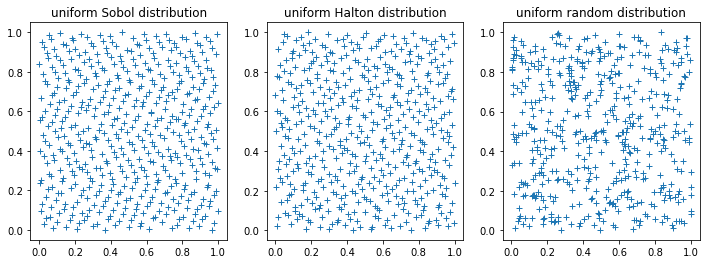

In [11]:
from scipy.stats import qmc

sobol_sampler = qmc.Sobol(d=2, scramble=True)
x_sobol = sobol_sampler.random(5000)
#x_sobol = sobol_sampler.random_base2(11) # generate 2^m points
print(x_sobol[:5])

halton_sampler = qmc.Halton(d=2, scramble=True)
x_halton = halton_sampler.random(5000);
print(x_halton[:5])

x_random = np.random.random((5000,2))
print(x_random[:5])

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(x_sobol[:500, 0], x_sobol[:500, 1], '+')
plt.title('uniform Sobol distribution')

plt.subplot(1,3,2)
plt.plot(x_halton[:500, 0], x_halton[:500, 1], '+')
plt.title('uniform Halton distribution')

plt.subplot(1,3,3)
plt.plot(x_random[:500, 0], x_random[:500, 1], '+')
plt.title('uniform random distribution')

plt.show()

Sobol sequences may be susceptible to some "striping," but the "scrambling" is supposed to take care of that.
It seems that generating a number of points that is exactly $2^m$ really does help.

**Exercise**: change the Sobol sequence call to use the `random_base2` method instead of `random`.
Does the graphical representation of the sequence look any different?

Finally, here is the QMC integration test again, this time with the SciPy version of the Halton sequence.

In [12]:
def scipy_integration_qMC(f, a, b, N):
    sum = 0.
    sum2 = 0.
    x_halton = halton_sampler.random(N) # on interval [0,1]
    for i in range(N):
        x = x_halton[i,0]*(b-a) + a
        sum += f(x)
        sum2 += pow(f(x),2)
    result = (b - a) * sum/N
    sigma = (b - a) * np.sqrt((sum2/N - pow(sum/N,2))/N)
    error = abs(result - 2.000)
    return (result, error)

for N in np.logspace(1, 5, num=5, dtype=int):
    print("N =", N)
    print("Trap:", integration_trapezoid(f, 0, np.pi, N))
    print("  MC:", integration_MC(f, 0, np.pi, N))
    print(" qMC:", integration_qMC(f, 0, np.pi, N))

N = 10
Trap: (1.9796508112164835, 0.020349188783516547)
  MC: (2.098243519138523, 0.09824351913852292)
 qMC: (2.210011379535336, 0.21001137953533622)
N = 100
Trap: (1.9998321638939918, 0.0001678361060082345)
  MC: (2.044234559520209, 0.04423455952020916)
 qMC: (2.0118825351761593, 0.011882535176159337)
N = 1000
Trap: (1.9999983517708506, 1.6482291493868928e-06)
  MC: (1.973039662344268, 0.026960337655731914)
 qMC: (2.000964010571766, 0.000964010571765872)
N = 10000
Trap: (1.999999983547363, 1.6452637030539563e-08)
  MC: (1.99474882642924, 0.005251173570760104)
 qMC: (2.0000273831076245, 2.738310762451235e-05)
N = 100000
Trap: (1.9999999998355142, 1.6448575834715484e-10)
  MC: (2.001533415256998, 0.0015334152569979054)
 qMC: (2.000001980817679, 1.9808176792146526e-06)
